In [15]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from IPython.display import display, clear_output
import os.path

In [32]:
products = [
    "G18-ABI-CONUS-BAND07", # GOES-16 East
    "G16-ABI-FD-BAND07", # GOES-18 West
]
km_per_pixel = 1.0
time_start = datetime.datetime(2025, 1, 7, 18, 16, 0, 0) # UTC time
time_end = datetime.datetime(2025, 1, 9, 3, 6, 0, 0)
time_step = datetime.timedelta(minutes=5) # GOES update rate
PST_offset = datetime.timedelta(hours=-8)

In [54]:
# pixel and physical coordinates
dx = 0.2
r = 64 # km

x_raw = np.arange(-r, r, 1)
X_raw, Y_raw = np.meshgrid(x_raw, x_raw)

x = np.arange(-r, r, dx)
X, Y = np.meshgrid(x, x)
extent = -r, r, -r, r

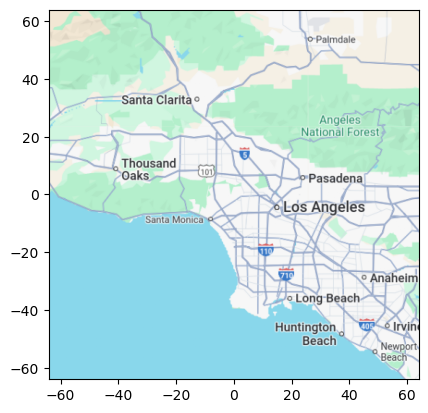

In [34]:
# overlay from Google Maps
reference = plt.imread("reference.png")
plt.imshow(reference, extent=extent)

In [35]:
# templates
shape = (128, 128)
ones = np.ones(shape)
zeros = np.zeros(shape)

In [42]:
fires = {
    "Palisade": {
        "offset": (-20, -5),
        "r": 20,
        "color": "black",
    },
    "Eaton": {
        "offset": (25, 10),
        "r": 15,
        "color": "purple",
    },
    "Hurst": {
        "offset": (-5, 25),
        "r": 10,
        "color": "red",
    },
    "Lidia": {
        "offset": (20, 40),
        "r": 15,
        "color": "blue",
    }
}

In [ ]:
time = time_start
while time < time_end:
    fig = plt.figure(figsize=(8,8), dpi=100)
    
    time += time_step * 10
    time_string = time.isoformat().replace("T","+")
    
    images = []
    for product in products:
        path = f"raw/{product}/{time}.png"
        if os.path.isfile(path):
            img = plt.imread(path)[:,:,0]
            img = np.where(img > 0.9, zeros, img) # fix overflowing issue
        else:
            img = ones
        images.append(img)
    data = np.clip(1 - 2 * (images[0] * images[1]) ** 0.5, 0, 1) # remap to highlight fires

    alpha = data ** 0.2 # mask to draw over street map
    alpha = np.where(data > 0.1, alpha, zeros)

    display(fig)
    plt.title(f"{(time + PST_offset)} PST")
    plt.imshow(data, extent=extent, cmap="inferno", vmin=0, vmax=1)
    plt.imshow(reference, extent=extent, alpha=0.5)
    plt.imshow(data, extent=extent, alpha=alpha, cmap="inferno", vmin=0, vmax=1)

    for key in fires:
        fire = fires[key]

        cx, cy = fire["offset"]
        # the y coordinate is flipped
        mask = (X_raw - cx)**2 + (Y_raw + cy)**2 < fire["r"]**2
        
        fire["area"] = np.sum(data[mask[0]] > 0.1) * (km_per_pixel**2)
        
        patch = plt.Circle(
            fire["offset"], fire["r"], color=fire["color"], 
            fill=False, label=f"{key} Fire: {fire['area']} km$^2$"
        )
        plt.gca().add_patch(patch)
    plt.legend()
    
    plt.xlabel("""kilometers
Satellite analysis can be inaccurate. Refer to fire.ca.gov for official information.
Data: Google Maps, NOAA GOES, UW SSEC  | Code: github.com/xingyzt/fire
""")
    clear_output(wait=True)

    plt.savefig(f"render/{time_string}.png")
    plt.pause(.1)
    plt.close()

<Figure size 800x800 with 0 Axes>